<a href="https://colab.research.google.com/github/haryobimo96/dicoding-ML/blob/main/NLPDicoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dicoding Submission for "Learning Machine Learning Development"
# NLP Project

By: Haryo Bimo Cokrokusumo

Depok, Jawa Barat

**Step 1**: Upload the dataset needed. 

The dataset is retrieved from the IMDB Movie Review Dataset (https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMDB_Dataset.csv.zip to IMDB_Dataset.csv.zip


In [ ]:
!unzip IMDB_Dataset.csv.zip

Archive:  IMDB_Dataset.csv.zip
  inflating: IMDB Dataset.csv        


**Step 2**: Load the dataframe

Note: positive sentiments are labelled as 1 and negative sentiments are labelled as 0

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing

df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
lb = preprocessing.LabelBinarizer()
df['sentiment'] = lb.fit_transform(df['sentiment'])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
print(df['sentiment'].value_counts())

1    25000
0    25000
Name: sentiment, dtype: int64


**Step 3**: Tokenize the review data and pre-process it to make it trainable by the RNN model

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

review = df['review'].values
sentiment = df['sentiment'].values
(review_train, review_valid, 
 sentiment_train, sentiment_valid) = train_test_split(review, 
                                                      sentiment, 
                                                      test_size=0.2,
                                                      random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='-')
tokenizer.fit_on_texts(review_train)
tokenizer.fit_on_texts(review_valid)
sequences_train = tokenizer.texts_to_sequences(review_train)
sequences_valid = tokenizer.texts_to_sequences(review_valid)

In [ ]:
print(tokenizer.word_index)
print(sequences_train[0])
print(review_train[0])

{'-': 1, 'the': 2, 'and': 3, 'a': 4, 'of': 5, 'to': 6, 'is': 7, 'br': 8, 'in': 9, 'it': 10, 'i': 11, 'this': 12, 'that': 13, 'was': 14, 'as': 15, 'for': 16, 'with': 17, 'movie': 18, 'but': 19, 'film': 20, 'on': 21, 'not': 22, 'you': 23, 'are': 24, 'his': 25, 'have': 26, 'be': 27, 'one': 28, 'he': 29, 'all': 30, 'at': 31, 'by': 32, 'an': 33, 'they': 34, 'so': 35, 'who': 36, 'from': 37, 'like': 38, 'or': 39, 'just': 40, 'her': 41, 'out': 42, 'about': 43, 'if': 44, "it's": 45, 'has': 46, 'there': 47, 'some': 48, 'what': 49, 'good': 50, 'when': 51, 'more': 52, 'very': 53, 'up': 54, 'no': 55, 'time': 56, 'my': 57, 'even': 58, 'would': 59, 'she': 60, 'which': 61, 'only': 62, 'really': 63, 'see': 64, 'story': 65, 'their': 66, 'had': 67, 'can': 68, 'me': 69, 'well': 70, 'were': 71, 'than': 72, 'much': 73, 'we': 74, 'bad': 75, 'been': 76, 'get': 77, 'do': 78, 'great': 79, 'other': 80, 'will': 81, 'also': 82, 'into': 83, 'people': 84, 'because': 85, 'how': 86, 'first': 87, 'him': 88, 'most': 89,

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_train = pad_sequences(sequences_train,padding='post',maxlen=30)
padded_valid = pad_sequences(sequences_valid,padding='post',maxlen=30)

**Step 4**: Build and compile the model with these chosen layers and optimizer

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=10000, 
                                                       output_dim=64),
                             tf.keras.layers.LSTM(64),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.8),
                             tf.keras.layers.Dense(32, activation='relu'),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(1, activation = 'sigmoid'),
])

In [ ]:
model.summary()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

**Step 4**: Train the model with added weight decay (negative exponential) and early stopping callback

Early stopping is applied as there is an indication that the model is on its way to overfitting.

In [ ]:
import math

def step_decay(epoch):
    initial_lrate = 0.0001
    exp_c = 0.3
    lrate = initial_lrate * math.exp(-exp_c*epoch)
    return lrate

class History(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.val_losses = []
       self.accuracies = []
       self.val_accuracies = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.val_losses.append(logs.get('val_loss'))
       self.accuracies.append(logs.get('accuracy'))
       self.val_accuracies.append(logs.get('val_accuracy'))
       self.lr.append(step_decay(len(self.losses)))

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=2,
    mode='min', baseline=None, restore_best_weights=True
    )

history = History()
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
callbacks_list = [history,lrate,early_stop]

hist = model.fit(padded_train,
                 sentiment_train,
                 epochs=20,
                 validation_data=(padded_valid, sentiment_valid),
                 callbacks = callbacks_list)

Epoch 1/20
1250/1250 [==============================] - 15s 11ms/step - loss: 0.6606 - accuracy: 0.5837 - val_loss: 0.5146 - val_accuracy: 0.7516
Epoch 2/20
1250/1250 [==============================] - 14s 12ms/step - loss: 0.4775 - accuracy: 0.7886 - val_loss: 0.4386 - val_accuracy: 0.7985
Epoch 3/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.4127 - accuracy: 0.8274 - val_loss: 0.4291 - val_accuracy: 0.7981
Epoch 4/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.3835 - accuracy: 0.8467 - val_loss: 0.4282 - val_accuracy: 0.8006
Epoch 5/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.3632 - accuracy: 0.8575 - val_loss: 0.4363 - val_accuracy: 0.8005
Epoch 6/20
1250/1250 [==============================] - 13s 11ms/step - loss: 0.3498 - accuracy: 0.8661 - val_loss: 0.4369 - val_accuracy: 0.7998
Epoch 7/20
1250/1250 [==============================] - 14s 11ms/step - loss: 0.3409 - accuracy: 0.8709 - val_loss: 0.4414 -

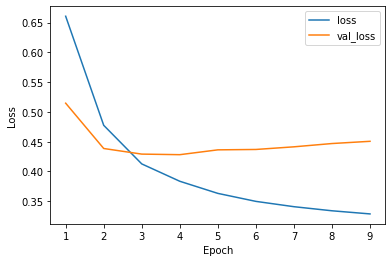

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = np.arange(len(history.losses)) + 1
loss = plt.plot(X, history.losses)
val_loss = plt.plot(X, history.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])

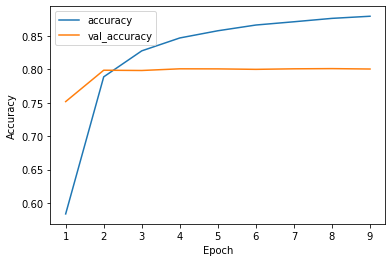

In [ ]:
y = np.arange(len(history.accuracies)) + 1
loss = plt.plot(y, history.accuracies)
val_loss = plt.plot(y, history.val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

**Step 5**: Save the tokenizer and the model for later use.

In [ ]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

model.save('mymodel.h5')


**Step 6**: Test the model for some self-made reviews.

Note: the negative review (the first one) gets a score of 0.070627 and the positive review (the second one) gets 0.834558. Since the sentiments are labelled 0 for negative ones and 1 for positive ones, the prediction seems pretty accurate here.

In [ ]:
custom_review = "This movie doesn't live up to its expectations, \
the plot is really rushed without a lot of character development going on. \
Overall, it is pretty disappointing to see the deterioration in quality \
compared to the prequel"

In [ ]:
seq = tokenizer.texts_to_sequences([custom_review])
pad_seq = pad_sequences(seq,padding='post',maxlen=30)

In [ ]:
model.predict(pad_seq)

array([[0.070627]], dtype=float32)

In [ ]:
custom_review_2 = "I kinda enjoy this movie. Even though there is couple of\
things needed to be improved (such as the plot plateau in the middle of the movie\
and action scenes which are kinda overwhelming) overall this movie is still as\
good as its prequel while still bringing the latter's uniqueness in world setting"

In [ ]:
seq_2 = tokenizer.texts_to_sequences([custom_review_2])
pad_seq_2 = pad_sequences(seq_2,padding='post',maxlen=30)

In [ ]:
model.predict(pad_seq_2)

array([[0.8343558]], dtype=float32)